# Chapitre 4: Maîtriser l’analyse technique en Python

## Objectifs du chapitre

- Comprendre le rôle des indicateurs techniques dans la lecture des tendances
- Mettre en œuvre les principaux indicateurs en Python : RSI, MACD, OBV, A/D, CMF
- Visualiser les signaux de surachat, survente, accumulation et distribution
- Interpréter graphiquement les divergences entre prix et volume
- Créer un script Python d’analyse technique applicable à n’importe quel actif


In [37]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt



In [38]:
# Télécharger les données de l'action Apple
apple = yf.download("AAPL", start="2021-01-01", end="2024-12-31")
# Ça fonctionne même si yfinance renvoie un DataFrame multi-niveaux
apple.columns = apple.columns.droplevel('Ticker')
apple.dropna(inplace=True)
apple.tail()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2024-12-23,254.989655,255.369227,253.171646,254.490204,40858800
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100
2024-12-27,255.309296,258.415896,252.782075,257.546826,42355300
2024-12-30,251.923019,253.221595,250.474615,251.952985,35557500


## 2. Calculer et interpréter le RSI

Le **RSI (Relative Strength Index)** est un indicateur de momentum qui mesure la vitesse et l'amplitude des variations de prix. 

Il oscille entre 0 et 100 et permet d'identifier des situations de :

- **Surachat** : RSI > 70  
- **Survente** : RSI < 30

$$
RSI = 100 - \left( \frac{100}{1 + RS} \right)
$$
avec :

$$
RS = \frac{\text{Moyenne des gains sur } n \text{ périodes}}{\text{Moyenne des pertes sur } n \text{ périodes}}
$$

### 🔍 Interprétation :

- RSI > 70 : actif potentiellement suracheté, attention à un repli
- RSI < 30 : actif potentiellement survendu, possible rebond

Le RSI est souvent utilisé avec une période de **14 jours**.

In [39]:
apple['Delta'] = apple['Close'].diff() # Calcul des différences 
apple


Price,Close,High,Low,Open,Volume,Delta
Date,,,,,,
2021-01-04,126.405220,130.507697,123.816749,130.419790,143301900,NaN
2021-01-05,127.968079,128.681140,125.447982,125.897308,97664900,1.562859
2021-01-06,123.660492,128.007173,123.445599,124.754490,155088000,-4.307587
2021-01-07,127.880188,128.573709,124.891240,125.379631,109578200,4.219696
2021-01-08,128.983963,129.550498,127.206214,129.355130,105158200,1.103775
...,...,...,...,...,...,...
2024-12-23,254.989655,255.369227,253.171646,254.490204,40858800,0.779144
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,2.926788
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,0.819061


In [40]:
# Calcul des variations journalières
apple['diff'] = apple['Close'].diff()

# Séparer les gains et pertes
apple['gain'] = apple['diff'].apply(lambda x: x if x > 0 else 0)
apple['loss'] = apple['diff'].apply(lambda x: -x if x < 0 else 0)

# Période du RSI
window = 14

# Moyenne mobile simple sur 14 jours (vous peux pouvez utiliser ewm pour plus de fluidité)
apple['avg_gain'] = apple['gain'].rolling(window=window).mean()
apple['avg_loss'] = apple['loss'].rolling(window=window).mean()

# Calcul du RS (relative strength)
apple['rs'] = apple['avg_gain'] / apple['avg_loss']

# Calcul du RSI
apple['RSI'] = 100 - (100 / (1 + apple['rs']))

apple['RSI'].describe()


count    991.000000
mean      54.013263
std       17.744718
min        3.179770
25%       40.370649
50%       54.455863
75%       67.794578
max       96.163014
Name: RSI, dtype: float64

In [41]:
!pip install ta

In [42]:
import ta  # pip install ta
# Créer un objet RSI avec une période de 14 jours
rsi_indicator = ta.momentum.RSIIndicator(close=apple['Close'], window=14)

# Ajouter la colonne RSI au DataFrame
apple['RSI_14'] = rsi_indicator.rsi()

# Afficher les statistiques descriptives
apple['RSI_14'].describe()

count    991.000000
mean      53.788823
std       12.236719
min       22.223692
25%       43.887191
50%       54.173666
75%       63.440452
max       81.323563
Name: RSI_14, dtype: float64

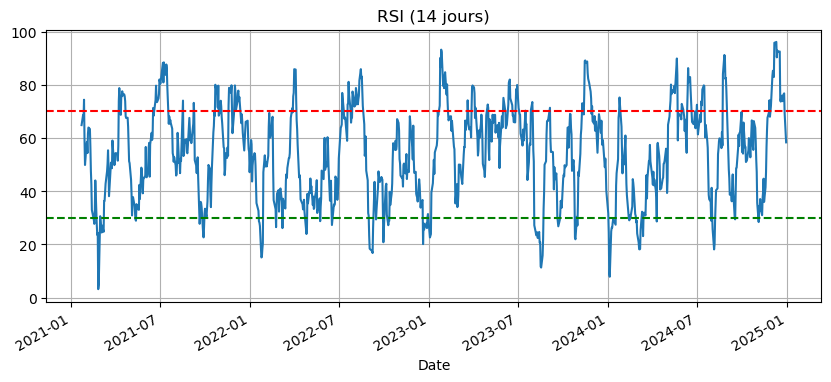

In [43]:




plt.figure(figsize=(10, 4))
apple['RSI'].plot(title='RSI (14 jours)')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.grid()
plt.show()


In [44]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe RSI
fig.add_trace(go.Scatter(
    x=apple.index,
    y=apple['RSI'],
    mode='lines',
    name='RSI (14 jours)',
    line=dict(color='blue')
))

# Lignes horizontales : Surachat (70) et Survente (30)
fig.add_trace(go.Scatter(
    x=[apple.index.min(), apple.index.max()],
    y=[70, 70],
    mode='lines',
    name='Seuil de surachat (70)',
    line=dict(color='red', dash='dash')
))

fig.add_trace(go.Scatter(
    x=[apple.index.min(), apple.index.max()],
    y=[30, 30],
    mode='lines',
    name='Seuil de survente (30)',
    line=dict(color='green', dash='dash')
))

# Mise en page
fig.update_layout(
    title='Indice RSI avec niveaux de surachat/survente',
    xaxis_title='Date',
    yaxis_title='RSI',
    template='plotly_white',
    legend_title='Légende'
)

fig.show()


## 3. Analyser la tendance avec le MACD

Le **MACD (Moving Average Convergence Divergence)** est un indicateur technique très populaire qui permet de suivre la **dynamique d’un actif**. Il est basé sur la différence entre deux **moyennes mobiles exponentielles** (EMA), généralement à 12 et 26 périodes.

### À quoi sert le MACD ?
- Identifier les **changements de dynamique** du marché
- Repérer les **points d’entrée et de sortie**
- Visualiser le **momentum** (accélération/décélération d’une tendance)
- Confirmer ou invalider un signal donné par le prix seul


### Composantes du MACD

1. **EMA 12** : moyenne mobile exponentielle des 12 dernières clôtures → représente le **prix moyen à court terme**
2. **EMA 26** : moyenne mobile exponentielle des 26 dernières clôtures → représente le **prix moyen à long terme**
3. **MACD Line** : différence entre EMA 12 et EMA 26 → met en évidence les divergences de momentum
4. **Signal Line** : EMA de la MACD sur 9 périodes → permet de lisser les variations de la MACD
5. **Histogramme** : différence entre MACD et sa ligne Signal → reflète la force du momentum



Le MACD est défini comme :

$$
MACD_t = EMA_{12}(P_t) - EMA_{26}(P_t)
$$

Ensuite, on calcule une **ligne de signal** :

$$
Signal_t = EMA_{9}(MACD_t)
$$

Et l’**histogramme MACD** (différence entre MACD et sa ligne de signal) :

$$
Hist_t = MACD_t - Signal_t
$$


### Interprétation :
- Lorsque **MACD croise au-dessus** de la ligne de signal → **signal d’achat**
- Lorsque **MACD croise en dessous** → **signal de vente**
- L’**histogramme** permet de visualiser le **momentum** (positif ou négatif)



💡 Le MACD est un outil de **suivi de tendance** : il fonctionne mieux dans des marchés en tendance (haussière ou baissière) que dans les phases de range.

In [45]:
apple['EMA_12'] = apple['Close'].ewm(span=12, adjust=False).mean()   
apple['EMA_26'] = apple['Close'].ewm(span=26, adjust=False).mean()

In [46]:
apple['MACD'] = apple['EMA_12'] - apple['EMA_26']
apple['Signal'] = apple['MACD'].ewm(span=9, adjust=False).mean()
apple.head()


Price,Close,High,Low,Open,Volume,Delta,diff,gain,loss,avg_gain,avg_loss,rs,RSI,RSI_14,EMA_12,EMA_26,MACD,Signal
Date,,,,,,,,,,,,,,,,,,
2021-01-04,126.405220,130.507697,123.816749,130.419790,143301900,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,126.405220,126.405220,0.000000,0.000000
2021-01-05,127.968079,128.681140,125.447982,125.897308,97664900,1.562859,1.562859,1.562859,0.000000,NaN,NaN,NaN,NaN,NaN,126.645660,126.520987,0.124672,0.024934
2021-01-06,123.660492,128.007173,123.445599,124.754490,155088000,-4.307587,-4.307587,0.000000,4.307587,NaN,NaN,NaN,NaN,NaN,126.186403,126.309099,-0.122696,-0.004592
2021-01-07,127.880188,128.573709,124.891240,125.379631,109578200,4.219696,4.219696,4.219696,0.000000,NaN,NaN,NaN,NaN,NaN,126.446985,126.425476,0.021510,0.000629
2021-01-08,128.983963,129.550498,127.206214,129.355130,105158200,1.103775,1.103775,1.103775,0.000000,NaN,NaN,NaN,NaN,NaN,126.837290,126.614993,0.222296,0.044962


In [47]:
apple['Histogram'] = apple['MACD'] - apple['Signal'] 
apple.head()

Price,Close,High,Low,Open,Volume,Delta,diff,gain,loss,avg_gain,avg_loss,rs,RSI,RSI_14,EMA_12,EMA_26,MACD,Signal,Histogram
Date,,,,,,,,,,,,,,,,,,,
2021-01-04,126.405220,130.507697,123.816749,130.419790,143301900,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,126.405220,126.405220,0.000000,0.000000,0.000000
2021-01-05,127.968079,128.681140,125.447982,125.897308,97664900,1.562859,1.562859,1.562859,0.000000,NaN,NaN,NaN,NaN,NaN,126.645660,126.520987,0.124672,0.024934,0.099738
2021-01-06,123.660492,128.007173,123.445599,124.754490,155088000,-4.307587,-4.307587,0.000000,4.307587,NaN,NaN,NaN,NaN,NaN,126.186403,126.309099,-0.122696,-0.004592,-0.118104
2021-01-07,127.880188,128.573709,124.891240,125.379631,109578200,4.219696,4.219696,4.219696,0.000000,NaN,NaN,NaN,NaN,NaN,126.446985,126.425476,0.021510,0.000629,0.020881
2021-01-08,128.983963,129.550498,127.206214,129.355130,105158200,1.103775,1.103775,1.103775,0.000000,NaN,NaN,NaN,NaN,NaN,126.837290,126.614993,0.222296,0.044962,0.177334


/var/folders/_h/9jm4l3w973n8rgwzstgvzkzc0000gn/T/ipykernel_61092/1850006573.py:34: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



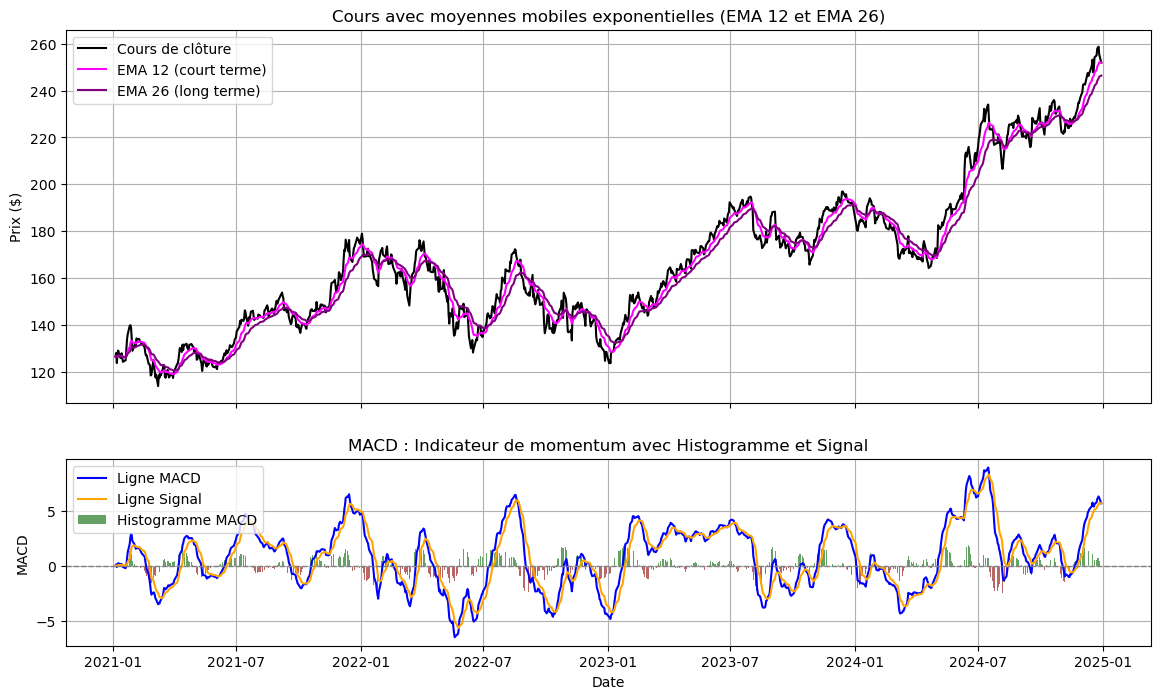

In [48]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Couleurs personnalisées pour l'histogramme
colors = ['darkgreen' if val >= 0 else 'darkred' for val in apple['Histogram']]

# Grille avec 2 sous-graphiques
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.2)


# ----- 1. Graphique des prix + EMA -----
ax1 = plt.subplot(gs[0])
ax1.plot(apple['Close'], label='Cours de clôture', color='black')
ax1.plot(apple['EMA_12'], label='EMA 12 (court terme)', color='magenta')
ax1.plot(apple['EMA_26'], label='EMA 26 (long terme)', color='purple')
ax1.set_title("Cours avec moyennes mobiles exponentielles (EMA 12 et EMA 26)")
ax1.set_ylabel("Prix ($)")
ax1.legend(loc='upper left')
ax1.grid(True)

# ----- 2. Graphique MACD -----
ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.bar(apple.index, apple['Histogram'], color=colors, alpha=0.6, label='Histogramme MACD')
ax2.plot(apple['MACD'], label='Ligne MACD', color='blue')
ax2.plot(apple['Signal'], label='Ligne Signal', color='orange')
ax2.axhline(0, color='gray', linewidth=1, linestyle='--')
ax2.set_title("MACD : Indicateur de momentum avec Histogramme et Signal")
ax2.set_ylabel("MACD")
ax2.legend(loc='upper left')
ax2.grid(True)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

## 4. Utiliser OBV pour suivre l’accumulation

L' **OBV (On-Balance Volume)** est un indicateur technique qui permet de mesurer la **pression d’achat et de vente** à travers les volumes. Il sert à détecter les phases d'accumulation (achats discrets) ou de distribution (ventes dissimulées) avant un mouvement de prix significatif.



Le **OBV cumule les volumes** de la manière suivante :

- Si le **cours de clôture** d’aujourd’hui est **supérieur** à celui d’hier → on **ajoute** le volume du jour au OBV.
- Si le cours de clôture est **inférieur** → on **soustrait** le volume.
- Si le cours est **inchangé** → le OBV reste identique.



### 🔢 Formule du OBV

Soit `OBV_t` la valeur de l’OBV au jour `t`, et `Volume_t` le volume ce même jour.

```math
OBV_t = 
\begin{cases}
OBV_{t-1} + Volume_t & \text{si } Close_t > Close_{t-1} \\
OBV_{t-1} - Volume_t & \text{si } Close_t < Close_{t-1} \\
OBV_{t-1}             & \text{si } Close_t = Close_{t-1}
\end{cases}
```

#### 1. **Tendance de l’OBV**
- 🔼 OBV en **hausse** → accumulation → les acheteurs prennent position discrètement.
- 🔽 OBV en **baisse** → distribution → les vendeurs sortent discrètement.

#### 2. **Divergence OBV / Prix**
- 🟢 Si le **prix stagne ou baisse**, mais que l’OBV **monte** → **signal haussier caché** (accumulation).
- 🔴 Si le **prix monte**, mais que l’OBV **baisse** → **signal baissier caché** (distribution).

#### 3. **Confirmation de tendance**
- Si l’OBV suit et renforce le mouvement du prix → la tendance est **saine**.
- Si l’OBV **ne suit plus** → prudence : possible retournement à venir.






In [49]:
def calculate_obv(data):
    """
    Calcule l'indicateur technique OBV (On-Balance Volume) à partir des colonnes 'Close' et 'Volume'.

    L'OBV mesure la pression d’achat et de vente à l’aide des volumes :
    - Si le prix de clôture du jour est supérieur à celui de la veille → on ajoute le volume au cumul.
    - S’il est inférieur → on soustrait le volume.
    - S’il est égal → l’OBV reste inchangé.

    Paramètres :
    -----------
    data : pd.DataFrame
        Un DataFrame contenant au minimum les colonnes 'Close' (cours de clôture) et 'Volume' (volume d’échange).

    Retour :
    --------
    pd.DataFrame
        Le même DataFrame avec une colonne supplémentaire 'OBV' représentant l'indicateur On-Balance Volume.

    Exemple :
    ---------
    >>> df = calculate_obv(df[['Close', 'Volume']])
    >>> df[['Close', 'OBV']].plot()
    """
    obv = [0]  # Initialiser avec 0
    close = data['Close'].values
    volume = data['Volume'].values

    for i in range(1, len(data)):
        if close[i] > close[i - 1]:
            obv.append(obv[-1] + volume[i])
        elif close[i] < close[i - 1]:
            obv.append(obv[-1] - volume[i])
        else:
            obv.append(obv[-1])

    data = data.copy()  # Pour éviter les effets de bord
    data['OBV'] = obv
    return data


In [50]:
apple_filtre = apple[['Close', 'Volume']]
apple_filtre


Price,Close,Volume
Date,,
2021-01-04,126.405220,143301900
2021-01-05,127.968079,97664900
2021-01-06,123.660492,155088000
2021-01-07,127.880188,109578200
2021-01-08,128.983963,105158200
...,...,...
2024-12-23,254.989655,40858800
2024-12-24,257.916443,23234700
2024-12-26,258.735504,27237100


In [51]:
# 3. Calcul de l’OBV
apple = calculate_obv(apple)
apple

Price,Close,High,Low,Open,Volume,Delta,diff,gain,loss,avg_gain,avg_loss,rs,RSI,RSI_14,EMA_12,EMA_26,MACD,Signal,Histogram,OBV
Date,,,,,,,,,,,,,,,,,,,,
2021-01-04,126.405220,130.507697,123.816749,130.419790,143301900,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,126.405220,126.405220,0.000000,0.000000,0.000000,0
2021-01-05,127.968079,128.681140,125.447982,125.897308,97664900,1.562859,1.562859,1.562859,0.000000,NaN,NaN,NaN,NaN,NaN,126.645660,126.520987,0.124672,0.024934,0.099738,97664900
2021-01-06,123.660492,128.007173,123.445599,124.754490,155088000,-4.307587,-4.307587,0.000000,4.307587,NaN,NaN,NaN,NaN,NaN,126.186403,126.309099,-0.122696,-0.004592,-0.118104,-57423100
2021-01-07,127.880188,128.573709,124.891240,125.379631,109578200,4.219696,4.219696,4.219696,0.000000,NaN,NaN,NaN,NaN,NaN,126.446985,126.425476,0.021510,0.000629,0.020881,52155100
2021-01-08,128.983963,129.550498,127.206214,129.355130,105158200,1.103775,1.103775,1.103775,0.000000,NaN,NaN,NaN,NaN,NaN,126.837290,126.614993,0.222296,0.044962,0.177334,157313300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,254.989655,255.369227,253.171646,254.490204,40858800,0.779144,0.779144,0.779144,0.000000,1.393469,0.493029,2.826343,73.865382,73.085636,248.778804,243.013334,5.765470,5.220889,0.544581,1891382000
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,2.926788,2.926788,2.926788,0.000000,1.576839,0.493029,3.198269,76.180657,75.750268,250.184595,244.117268,6.067327,5.390177,0.677150,1914616700
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,0.819061,0.819061,0.819061,0.000000,1.633203,0.493029,3.312590,76.812079,76.452857,251.500119,245.200101,6.300019,5.572145,0.727874,1941853800


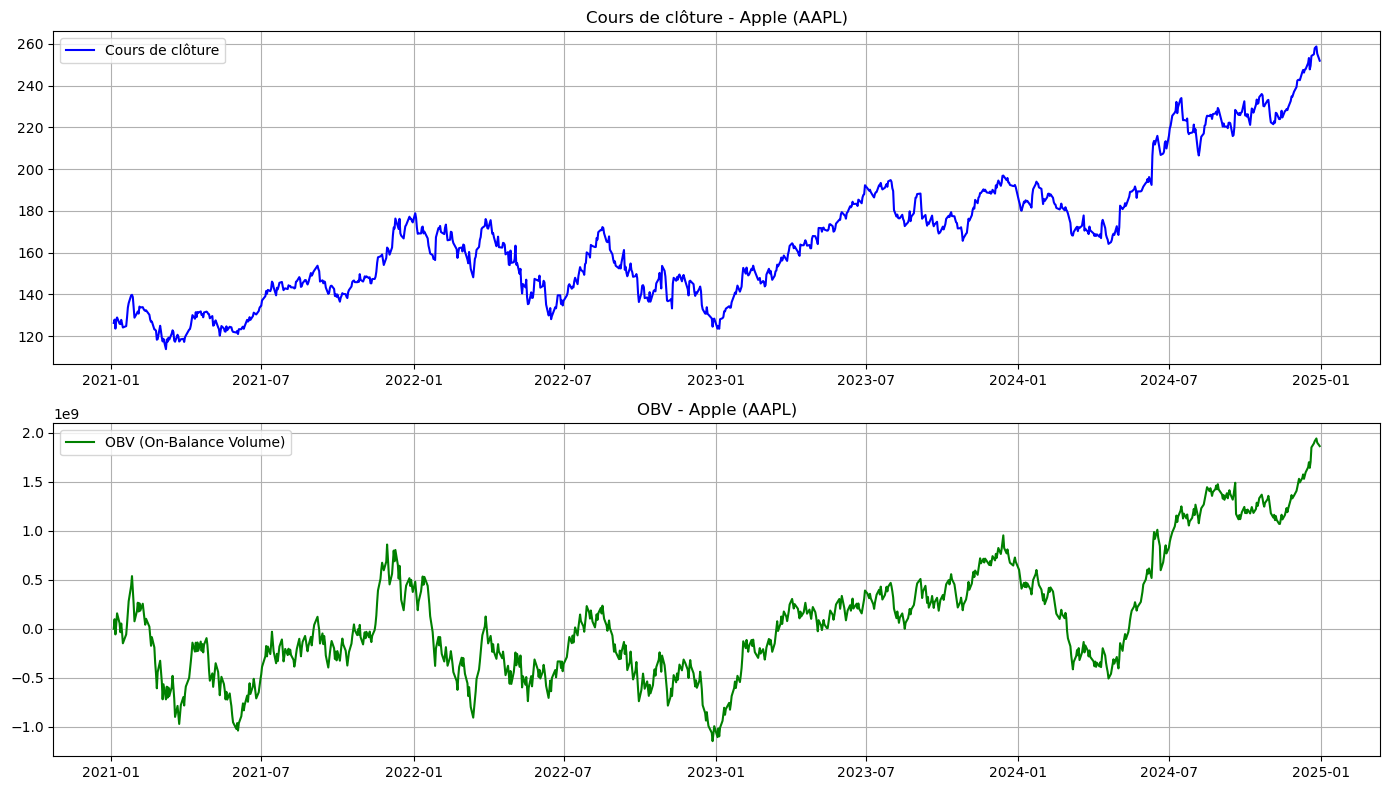

In [52]:
# 3. Affichage graphique
plt.figure(figsize=(14, 8))

# Cours de clôture
plt.subplot(2, 1, 1)
plt.plot(apple['Close'], label='Cours de clôture', color='blue')
plt.title("Cours de clôture - Apple (AAPL)")
plt.legend()
plt.grid()

# OBV
plt.subplot(2, 1, 2)
plt.plot(apple['OBV'], label='OBV (On-Balance Volume)', color='green')
plt.title("OBV - Apple (AAPL)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## 4: Étudier les indicateurs d’accumulation/distribution (A/D Line)

L'indicateur **Accumulation/Distribution Line (A/D Line)** est un outil d’analyse technique qui mesure la **pression acheteuse ou vendeuse** en combinant **prix** et **volume**.  

Il sert à détecter les phases d’**accumulation** (achats discrets) ou de **distribution** (ventes masquées), souvent avant que le prix ne bouge significativement.



$$
CLV_t = \frac{(Close_t - Low_t) - (High_t - Close_t)}{High_t - Low_t}
\quad \text{et} \quad
MFV_t = CLV_t \times Volume_t
\quad \text{et} \quad
A/D_t = A/D_{t-1} + MFV_t
$$

###  Signification des termes

- `Close_t` : prix de **clôture** du jour `t`  
- `Low_t` : **plus bas** du jour `t`  
- `High_t` : **plus haut** du jour `t`  
- `CLV_t` : **Close Location Value**, qui indique la position relative du prix de clôture dans la fourchette quotidienne :
  - `CLV_t ≈ +1` → clôture proche du **plus haut** → pression acheteuse
  - `CLV_t ≈ -1` → clôture proche du **plus bas** → pression vendeuse
  - `CLV_t ≈ 0` → clôture **centrée** dans la fourchette
- `MFV_t` : **Money Flow Volume** → volume pondéré par le CLV
- `A/D_t` : **Accumulation/Distribution** cumulée


###  Interprétation

-  **A/D Line monte** → pression d'achat (accumulation) → potentiel signal haussier.
-  **A/D Line descend** → pression de vente (distribution) → potentiel signal baissier.
- **Divergence** entre A/D et le prix :
  - Si le prix monte mais l’A/D stagne ou baisse → faiblesse du mouvement → méfiance.
  - Si le prix baisse mais l’A/D monte → accumulation cachée → possible retournement.



###  Résumé

| **Clôture**       | **CLV** approx. | Impact sur MFV | Impact sur A/D |
|------------------|------------------|----------------|----------------|
| Près du haut     | +1               | Volume positif | Hausse         |
| Milieu           | 0                | 0              | Stable         |
| Près du bas      | -1               | Volume négatif | Baisse         |


In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Données préparées
plot_data = apple.copy()

plot_data = plot_data.reset_index()

# Calcul du CLV
clv = ((plot_data['Close'] - plot_data['Low']) - (plot_data['High'] - plot_data['Close'])) / (plot_data['High'] - plot_data['Low'])
clv = clv.fillna(0)

# Calcul du MFV
mfv = clv * plot_data['Volume']

# Calcul de l'A/D
ad = mfv.cumsum()

# Ajout au DataFrame
plot_data['CLV'] = clv
plot_data['MFV'] = mfv
plot_data['AD'] = ad

plot_data.head()

Price,Date,Close,High,Low,Open,Volume,Delta,diff,gain,loss,...,RSI_14,EMA_12,EMA_26,MACD,Signal,Histogram,OBV,CLV,MFV,AD
0,2021-01-04,126.405220,130.507697,123.816749,130.419790,143301900,NaN,NaN,0.000000,0.000000,...,NaN,126.405220,126.405220,0.000000,0.000000,0.000000,0,-0.226277,-3.242589e+07,-3.242589e+07
1,2021-01-05,127.968079,128.681140,125.447982,125.897308,97664900,1.562859,1.562859,1.562859,0.000000,...,NaN,126.645660,126.520987,0.124672,0.024934,0.099738,97664900,0.558907,5.458564e+07,2.215975e+07
2,2021-01-06,123.660492,128.007173,123.445599,124.754490,155088000,-4.307587,-4.307587,0.000000,4.307587,...,NaN,126.186403,126.309099,-0.122696,-0.004592,-0.118104,-57423100,-0.905781,-1.404758e+08,-1.183160e+08
3,2021-01-07,127.880188,128.573709,124.891240,125.379631,109578200,4.219696,4.219696,4.219696,0.000000,...,NaN,126.446985,126.425476,0.021510,0.000629,0.020881,52155100,0.623339,6.830437e+07,-5.001167e+07
4,2021-01-08,128.983963,129.550498,127.206214,129.355130,105158200,1.103775,1.103775,1.103775,0.000000,...,NaN,126.837290,126.614993,0.222296,0.044962,0.177334,157313300,0.516667,5.433177e+07,4.320101e+06


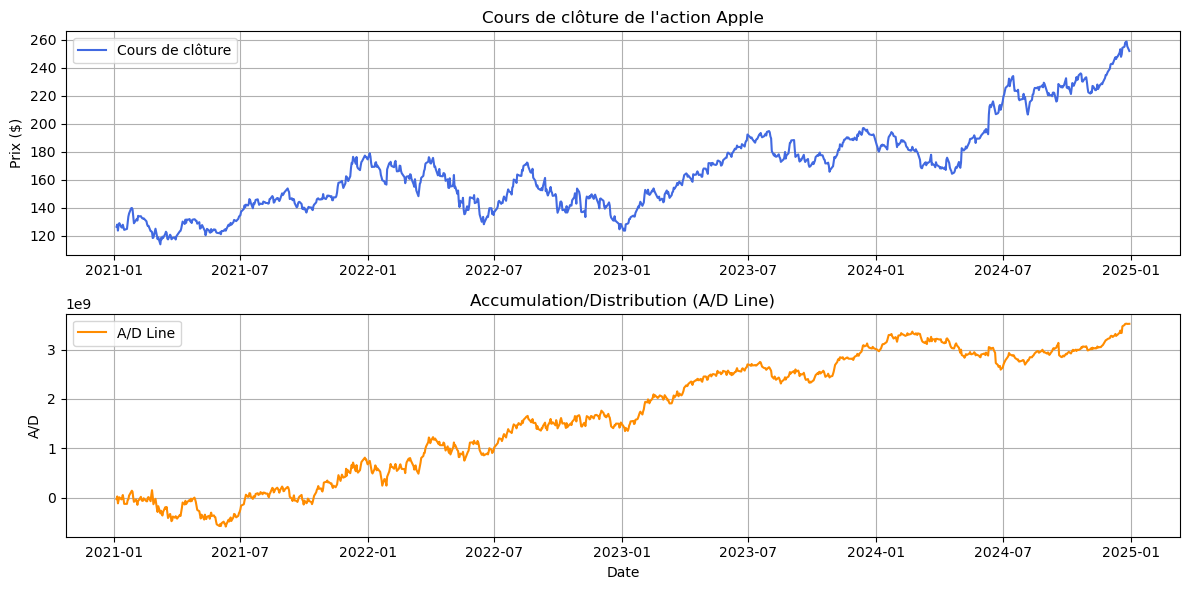

In [54]:
import matplotlib.pyplot as plt
# Taille globale de la figure
plt.figure(figsize=(12, 6))

# 1. Cours de clôture
plt.subplot(2, 1, 1)
plt.plot(plot_data['Date'], plot_data['Close'], label='Cours de clôture', color='royalblue')
plt.title("Cours de clôture de l'action Apple")
plt.ylabel('Prix ($)')
plt.grid(True)
plt.legend()

# 2. Ligne A/D
plt.subplot(2, 1, 2)
plt.plot(plot_data['Date'], plot_data['AD'], label='A/D Line', color='darkorange')
plt.title("Accumulation/Distribution (A/D Line)")
plt.xlabel('Date')
plt.ylabel('A/D')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()